In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
import numpy as np
import pandas as pd
from datetime import datetime, date

is_healthy = pd.read_csv("/data/segal_lab/home/zacharyl/is_healthy.csv")
is_healthy = list(is_healthy.loc[is_healthy.is_healthy,"RegistrationCode"])
##add age to the pbmc sample list
fname_all_samples = "/data/segal_lab/home/zacharyl/samples.csv"
df_all = pd.read_csv(fname_all_samples)

/tmp/ipykernel_42192/2031683948.py:9: DtypeWarning: Columns (12,23,24,27,28,33,36,39,41,42,43,45,47,48,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(fname_all_samples)


In [66]:
df_all["RegistrationCode"] = list(map(lambda x: "10K_" + str(x), df_all["participant_id"]))
df_all = df_all.loc[df_all.StudyTypeID_lc == 10,:]
df_all = df_all.loc[df_all.project_code == "P10K",:]
df_all = df_all.loc[df_all.sample_type == 8,:]
df_all = df_all.dropna(subset = list(filter(lambda x: "pbmc" in x, df_all.columns)))

In [77]:
df_all = df_all.drop_duplicates(subset = "participant_id", keep = "last")
subjects_all = pd.read_csv("/data/segal_lab/home/zacharyl/subjects_10k.csv").merge(how = "inner",right = df_all, on = "RegistrationCode").drop(["date_updated", "date_created"], axis = 1)
subjects_all["DOB"] = 15

def calculate_age(born):
    today = datetime.strptime(str(born["date_created"]).split(" ")[0], "%Y-%m-%d")
    return today.year - born["yob"] - ((today.month, today.day) < (born["month_of_birth"], born["DOB"]))
merged = subjects_all.merge(df_all, how = "inner", left_on = "RegistrationCode", right_on = "RegistrationCode")

merged = merged.dropna(subset = ["yob", "month_of_birth", "DOB", "date_updated"])
merged["age"] = merged.apply(calculate_age, axis = 1)
medications_df = pd.read_csv("/data/segal_lab/home/zacharyl/medications.csv")
exclusion_english = ["Tamoxifen", "Prednisone", "Maxibone", "Eltroxin", "Euthyrox"]
exclusion_matched =  []
for eng in exclusion_english:
    for heb in medications_df.medication.unique():
        if eng in heb:
            exclusion_matched.append(heb)
exclusion_matched = exclusion_matched[0:5]
exclude_based_on_medications = medications_df.iloc[list(map(lambda x: x in exclusion_matched, medications_df["medication"])),:].loc[:,"RegistrationCode"].unique()

In [68]:
pbmc_healthy = merged.loc[list(map(lambda x: x in is_healthy, merged.RegistrationCode)),:]
pbmc_healthy = pbmc_healthy.loc[list(map(lambda x: x not in exclude_based_on_medications, pbmc_healthy.RegistrationCode)),:]
pbmc_healthy = pbmc_healthy.loc[pbmc_healthy.age > 0, :]##exclude outliers and people with invalid  age
##keep only women
pbmc_healthy = pbmc_healthy.loc[pbmc_healthy.gender < 1, :].drop_duplicates(subset = ["RegistrationCode"], keep = "first") ##based on the metadata, 0: women, 1:men

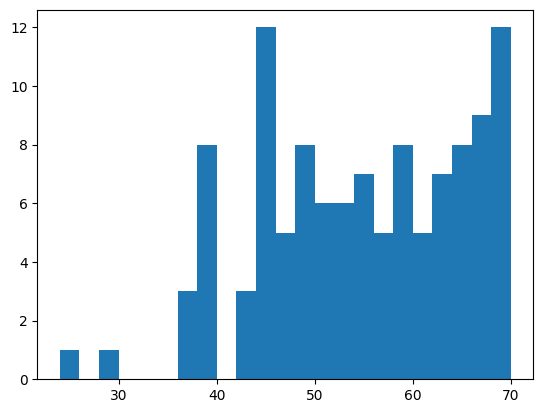

In [69]:
age_range = pbmc_healthy.age.max()- pbmc_healthy.age.min()
bin_width = 2
age_bins = list(zip(list(range(int(pbmc_healthy.age.min()), int(pbmc_healthy.age.max()), bin_width + 1)), list(range(int(pbmc_healthy.age.min()) + bin_width, int(pbmc_healthy.age.max()), bin_width + 1))))
##if we didn't hit the end of the age range, include a manual last bin
if age_bins[-1][1] < pbmc_healthy.age.max():
    age_bins.append((age_bins[-1][1] + 1, int(pbmc_healthy.age.max())))

##pick all people at the tails of the age distribution
upper_bound_all_samples = 39
lower_bound_all_samples = 70
number_per_bin = 10
##for each middle bin interval, randomly pick the set number of people in that age bin
samples = list(map(lambda bin_interval: np.random.choice(pbmc_healthy.loc[list(map(lambda age: bin_interval[0] <= age <= bin_interval[1], pbmc_healthy.age)), :].RegistrationCode, size = min(number_per_bin, len(pbmc_healthy.loc[list(map(lambda age: bin_interval[0] <= age <= bin_interval[1], pbmc_healthy.age)), :].RegistrationCode)), replace = False) if len(set(list(range(bin_interval[0], bin_interval[1] + 1, 1))).intersection(set(pbmc_healthy.age))) > 0 else None, list(filter(lambda x: x[0] > upper_bound_all_samples and x[1] < lower_bound_all_samples, age_bins))))
##drop the None entries (indicating no person has that age bin) from the list
samples = list(filter(lambda x: x is not None, samples))
##unpack the sampled tuples for each age bin
samples = list(set([y for x in samples for y in x]))
##include all young people
samples += list(pbmc_healthy.loc[pbmc_healthy.age <= upper_bound_all_samples, "RegistrationCode"].unique())
##include all old people
samples += list(pbmc_healthy.loc[pbmc_healthy.age >= lower_bound_all_samples, "RegistrationCode"].unique())

##Add required metadata for each sample that we are picking
samples_full = pd.DataFrame({"RegistrationCode": samples})
##use earlier samples for people with multiple samples, because we want a healthier cohort
samples_full = samples_full.merge(pbmc_healthy, on = "RegistrationCode", how = "inner")

##Make table with ages'
table = pd.DataFrame(age_bins)
table.columns = ["Lower_bound", "Upper_bound"]
number_per_bin = list(map(lambda bin_interval: len(pbmc_healthy.loc[list(map(lambda age: bin_interval[0] <= age <= bin_interval[1], pbmc_healthy.age)), :].RegistrationCode.unique()), age_bins))
table["number_per_bin"] = number_per_bin

##make a histogram of the age distribution of the selected people
plt.hist(samples_full["age"], list(range(int(pbmc_healthy.age.min()), int(pbmc_healthy.age.max()), 2)))
plt.show()

In [70]:
len(samples_full)

117

In [71]:
set(medications_df.merge(samples_full, left_on = "RegistrationCode", right_on = "RegistrationCode", how = "inner").medication).intersection(set(exclusion_matched))

set()

In [20]:
exclusion_matched

['טמוקסיפן / Tamoxifen',
 'פרדניזון / Prednisone',
 'מקסיבון / Maxibone',
 'אלטרוקסין / Eltroxin',
 'אלטרוקסין LF / Eltroxin-LF']

In [21]:
age_bins

[(24, 26),
 (27, 29),
 (30, 32),
 (33, 35),
 (36, 38),
 (39, 41),
 (42, 44),
 (45, 47),
 (48, 50),
 (51, 53),
 (54, 56),
 (57, 59),
 (60, 62),
 (63, 65),
 (66, 68),
 (69, 71),
 (72, 72)]

In [72]:
samples_full.to_csv("~/test_samples.csv")

In [137]:
len(samples_full)

119

In [73]:
list(filter(lambda x: "pbmc" in x, df_all.columns))

['pbmc_vitality', 'pbmc_cellml']